# VibeShare Model Analysis

This notebook provides a comparative analysis of various AI models based on their responses to specific prompts. It evaluates success rates, response characteristics, and the mention of specific AI frameworks, with a particular focus on the Agent Development Kit (ADK).

In [1]:
import json
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from vibeshare.src.data_models import FRAMEWORKS_TO_DETECT

# Set pandas display options for better readability in the detailed responses section
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Load data from the results JSON file
results_path = 'vibeshare_results.json'

try:
    with open(results_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} results from {results_path}.")
except FileNotFoundError:
    print("vibeshare_results.json not found. Please run analyze_vibeshare.py first.")
    data = []

Loaded 7 results from vibeshare_results.json.


## Framework Master List
The following frameworks are pre-vetted and actively searched for within model responses. This list includes major orchestration libraries and provider-specific SDKs.

In [2]:
print("Master list of frameworks monitored:")
for i, framework in enumerate(sorted(FRAMEWORKS_TO_DETECT), 1):
    print(f"{i:2}. {framework}")

Master list of frameworks monitored:
 1. adk
 2. agent development kit
 3. langchain


In [3]:
if data:
    df = pd.DataFrame(data)
    df = df[df['success'] == True]
    # Pre-calculate response length and filter for overview
    df['response_length'] = df['response'].apply(lambda x: len(x) if x is not None else 0)
    
    # display(df.head())

## Success Rate by Model
This chart shows the percentage of prompts that resulted in a successful API response for each model. Failures typically indicate authentication issues, quota limits, or model unavailability.

In [4]:
if not df.empty:
    success_counts = df.groupby('model_name')['success'].mean().reset_index()
    success_counts.rename(columns={'success': 'success_rate'}, inplace=True)
    
    display(HTML("<h3>Success Rate by Model</h3>"))
    display(success_counts.sort_values('success_rate', ascending=False).reset_index(drop=True))

,model_name,success_rate
0,gemini-cli-podman/adk-python,1.0
1,gemini-cli-podman/base,1.0
2,gemini/gemini-2.5-flash,1.0
3,gemini/gemini-2.5-flash-lite,1.0
4,gemini/gemini-2.5-pro,1.0
5,gemini/gemini-3-flash-preview,1.0
6,gemini/gemini-3-pro-preview,1.0


## Response Length Distribution
Analyzes the verbosity of successful responses. Models with higher median lengths may provide more detailed explanations or extensive code samples.

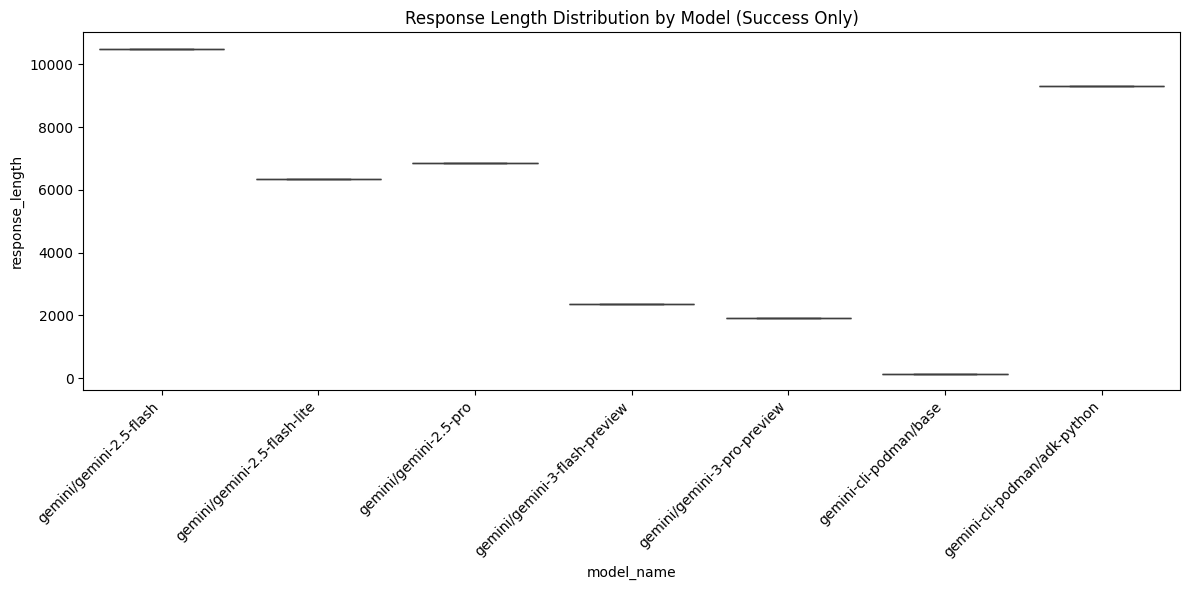

In [5]:
if not df.empty:
    df_success = df[df['success'] == True]
    if not df_success.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df_success, x="model_name", y="response_length")
        plt.title("Response Length Distribution by Model (Success Only)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No successful runs to visualize response length.")

## ADK Mentions
Specifically tracks how many successful responses mentioned the Agent Development Kit (ADK) or its variants. This is a key metric for awareness analysis.

In [6]:
if not df.empty:
    if 'was_adk_mentioned' in df.columns:
        df_success = df[df['success'] == True]
        adk_ratio = df_success.groupby('model_name')['was_adk_mentioned'].mean().reset_index()
        adk_ratio.rename(columns={'was_adk_mentioned': 'mention_ratio'}, inplace=True)
        
        display(HTML("<h3>Ratio of Responses Mentioning ADK by Model</h3>"))
        display(adk_ratio.sort_values('mention_ratio', ascending=False).reset_index(drop=True))

,model_name,mention_ratio
0,gemini-cli-podman/adk-python,1.0
1,gemini-cli-podman/base,0.0
2,gemini/gemini-2.5-flash,0.0
3,gemini/gemini-2.5-flash-lite,0.0
4,gemini/gemini-2.5-pro,0.0
5,gemini/gemini-3-flash-preview,0.0
6,gemini/gemini-3-pro-preview,0.0


## AI Framework Mentions by Model
A broader view of all detected frameworks across successful responses. This reveals which orchestration libraries are currently favored or most prominent in model training data.

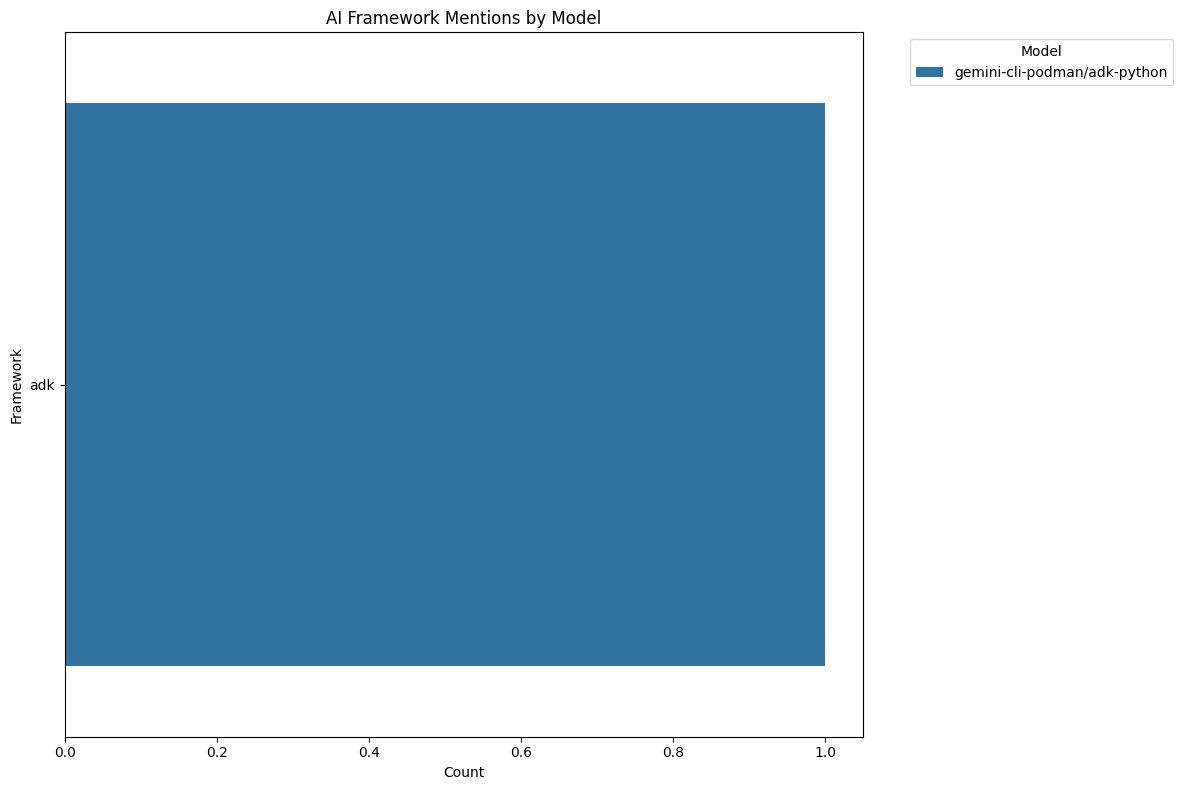

model_name,gemini-cli-podman/adk-python,Total
mentioned_frameworks,,
adk,1,1


In [7]:
if not df.empty and 'mentioned_frameworks' in df.columns:
    df_exploded = df.explode('mentioned_frameworks')
    df_frameworks = df_exploded.dropna(subset=['mentioned_frameworks'])
    
    if not df_frameworks.empty:
        plt.figure(figsize=(12, 8))
        sns.countplot(data=df_frameworks, y='mentioned_frameworks', hue='model_name')
        plt.title('AI Framework Mentions by Model')
        plt.xlabel('Count')
        plt.ylabel('Framework')
        plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Summary Table
        framework_counts = df_frameworks.groupby(['mentioned_frameworks', 'model_name']).size().unstack(fill_value=0)
        # Add a total column for easier analysis
        framework_counts['Total'] = framework_counts.sum(axis=1)
        display(HTML("<h3>AI Framework Mentions Summary Table</h3>"))
        display(framework_counts.sort_values('Total', ascending=False))

## Top 10 Frameworks Response Analysis
Below are the specific responses from each model to the prompt: "List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each."

In [8]:
target_prompt = "List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each."
if not df.empty:
    target_responses = df[df['prompt'] == target_prompt]
    if not target_responses.empty:
        for index, row in target_responses.iterrows():
            display(HTML(f"<h3>Model: {row['model_name']}</h3>"))
            print(row['response'])
            display(HTML("<hr>"))
    else:
        print("No responses found for the target prompt.")

No responses found for the target prompt.


## Detailed Responses by Model and Category
The table below shows full interaction details. Prompts and responses are truncated to 500 characters for concise viewing while maintaining a structured layout.

In [9]:
if not df.empty:
    df_sorted = df.sort_values(by=['model_name', 'category'])
    grouped = df_sorted.groupby(['model_name', 'category'])
    
    for (model, category), group in grouped:
        display(HTML(f"<h3>Model: {model} | Category: {category}</h3>"))
        
        cols = ['prompt', 'response', 'was_adk_mentioned', 'mentioned_frameworks', 'success', 'error_message']
        cols = [c for c in cols if c in group.columns]
        
        display_df = group[cols].copy()
        for col in ['prompt', 'response']:
            if col in display_df.columns:
                display_df[col] = display_df[col].apply(lambda x: (str(x)[:500] + '...') if x and len(str(x)) > 500 else x)

        # Apply style to render newlines in text columns
        text_cols = [c for c in ['prompt', 'response'] if c in display_df.columns]
        if text_cols:
            styler = display_df.style.set_properties(subset=text_cols, **{'white-space': 'pre-wrap', 'text-align': 'left'})
            display(styler)
        else:
            display(display_df)

        display(HTML("<hr>"))

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
6,How do I use the API?,"To use the API, you should start by exploring the quickstart guide. I'll read the contents of the `quickstart` directory to provide you with a summary. Okay, I see an `agent.py` file in the quickstart. I'll read that file to understand the API usage and explain it to you. Based on the `quickstart/agent.py` file, here's how to use the API: 1. **Import `Agent`:** ```python from google.adk.agents.llm_agent import Agent ``` 2. **Define Tool Functions:** Create Python functions that y...",True,['adk'],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
5,How do I use the API?,I'll start by listing the files in the current directory to find documentation or examples. The directory is empty. What API are you referring to?,False,[],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
0,How do I use the API?,"Using an API (Application Programming Interface) is like ordering food at a restaurant: * **You** are the client (your code, a web browser, a mobile app). * The **API** is the menu and the waiter (it tells you what you can order and takes your order). * The **server** is the kitchen (it prepares your order based on the API's instructions). * The **response** is your food (the data you requested). Since ""the API"" can refer to *any* API, I'll give you a general guide. The specific steps ...",False,[],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
1,How do I use the API?,"That's a great question! To give you the best and most specific answer, I need a little more information. **""The API"" is very broad!** To help me understand which API you're referring to, please tell me: 1. **What specific API are you trying to use?** (e.g., ""the Twitter API,"" ""the Google Maps API,"" ""the Stripe API,"" ""the OpenAI API,"" ""a custom API for my company's internal service,"" etc.) Once I know which API you're interested in, I can provide much more tailored guidance. However, in the...",False,[],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
2,How do I use the API?,"Of course! That's an excellent question. The term ""API"" (Application Programming Interface) is very broad, so I'll answer this in two parts: 1. **How to use my API** (the Google Generative AI API that powers this conversation). 2. **A general guide on how to use *any* API**, with a simple, practical example. --- ### 1. How to Use My API (The Google Gemini API) I am a large language model from Google, and you can access my capabilities through the **Google AI for Developers** platform, spec...",False,[],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
3,How do I use the API?,"To give you the right instructions, I need to know **which API** you are referring to (e.g., OpenAI, Google Maps, Twitter, or a private company API). However, almost all modern APIs follow a similar workflow. Here is a universal guide on how to use an API: --- ### 1. Get Your API Key Most APIs require authentication so they know who is making the request. * **Sign up** for the service. * Look for a **Dashboard** or **Developer Settings**. * Generate an **API Key** (keep this secret!). ...",False,[],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
4,How do I use the API?,"To give you the correct instructions, I need to know **which specific API you are trying to use.** Are you trying to use the **OpenAI API** (to build a chatbot like me), the **Google Maps API**, a **Twitter/X API**, or something else entirely? However, if you want a **general guide on how to use almost any REST API**, here are the universal steps: ### 1. Get an API Key Most APIs require you to sign up for an account on their developer platform to get a secret code called an **API Key** (or Ac...",False,[],True,None
